In [2]:
import pandas as pd
import os
import numpy as np
import feather
import pandas_profiling
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
%matplotlib inline
register_matplotlib_converters()
import pickle
DATA_PATH = '/home/users/ucadatalab_group/davidgg/SHARED/SOLAR/data'
# We load the final df, normalized with clearsky, 16 sensors
with open(os.path.join(DATA_PATH,'oahu_min_final.pkl'),'rb') as file:
    df = pickle.load(file)

In [22]:
# We load the info of the sensors to extract the longitude information
info = pd.read_csv(os.path.join(DATA_PATH,'info.csv'))

info.Location = info.Location.apply(lambda x: (x[:2] + x[-2:]).replace('_', ''))
info.index = info.Location
# Sorted longitudes
longs = info['Longitude'].sort_values(ascending=False)
longs.drop('AP3',inplace=True)
# Sort df sensors by longitude
df = df[longs.index]

In [7]:
pandas_profiling.ProfileReport(df,bins=20,correlation_threshold=0.95)

Number of variables,17
Number of observations,355387
Total Missing (%),0.0%
Total size in memory,46.1 MiB
Average record size in memory,136.0 B
Numeric,16
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,0


In [36]:
import sys
sys.path.insert(0,'/'.join(os.getcwd().split('/')[:-1]+['src']))
from utils.df_to_roll import df_to_roll

df_roll = df_to_roll(df,width=10,step=1)

In [39]:
longs_np = longs.index.to_numpy()
n_sensors = len(longs_np)
print('Number of sensors considered:',n_sensors)
times = df_roll.columns.levels[0].tolist()
chosen_times = times[1:10:1]
print('Chosen times slices as features:',chosen_times)
print('Number of time slices considered:',len(chosen_times))

Number of sensors considered: 16
Chosen times slices as features: ['t-1', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9']
Number of time slices considered: 9


In [41]:
# Split train-test, approximately 12 and 4 months respectively
df_train, df_test = df_roll[:'2011-07-31'], df_roll['2011-08-01':]

In [53]:
df_train.shape[1]%n_sensors==0

True

In [78]:
dates = df_train.index.to_numpy(dtype='datetime64')
hour_of_the_day = (dates - dates.astype('datetime64[D]')).astype(int)/60/60/10**9
day_of_the_year = (dates - dates.astype('datetime64[Y]')).astype(int)/60/60/10**9/24
time_feat_np = np.vstack([np.sin(2*np.pi*hour_of_the_day/24.),np.cos(2*np.pi*hour_of_the_day/24.),
           np.sin(2*np.pi*day_of_the_year/365),np.cos(2*np.pi*day_of_the_year/365)]).T

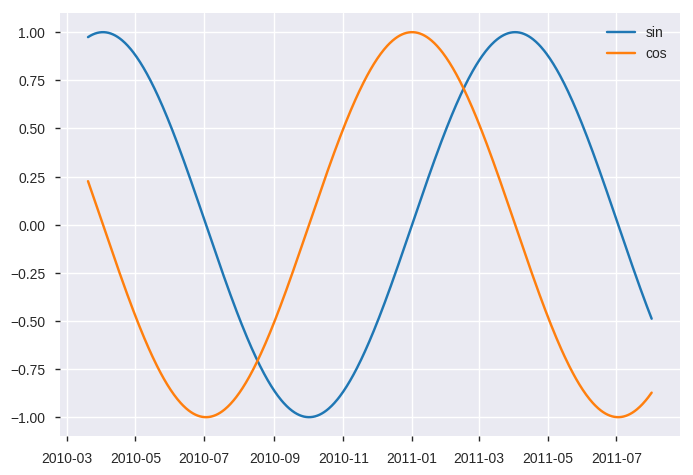

In [99]:
plt.plot(dates,time_feat_np[:,2],label='sin')
plt.plot(dates,time_feat_np[:,3],label='cos')
plt.legend()
plt.show()

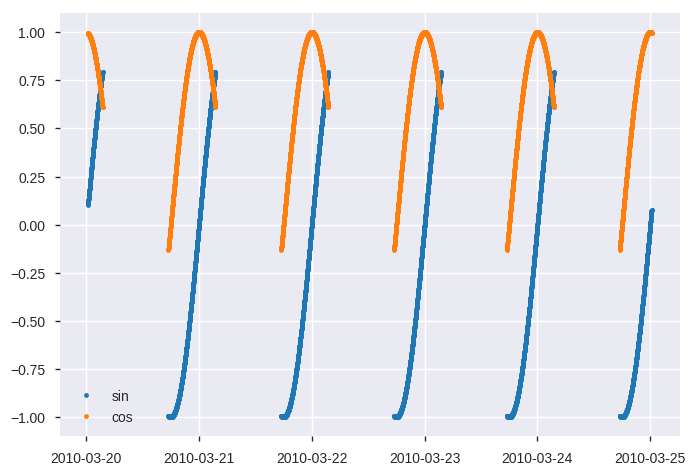

In [111]:
plt.plot_date(dates[:3000],time_feat_np[:3000,0], linestyle='', marker='.',label='sin')
plt.plot_date(dates[:3000],time_feat_np[:3000,1], linestyle='', marker='.',label='cos')
plt.legend()
plt.show()

SENSOR: AP5
0.7009578394539423


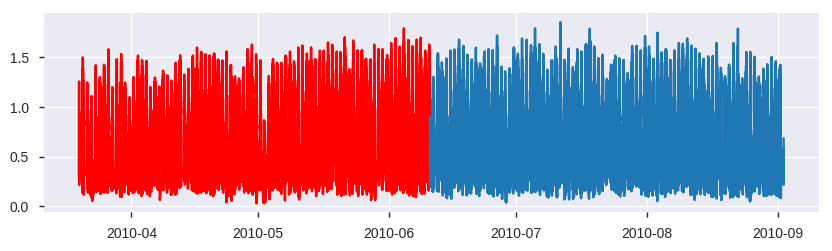

0.5696878659097668


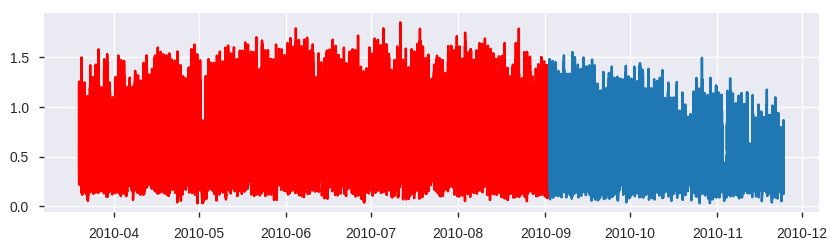

0.4479689905950863


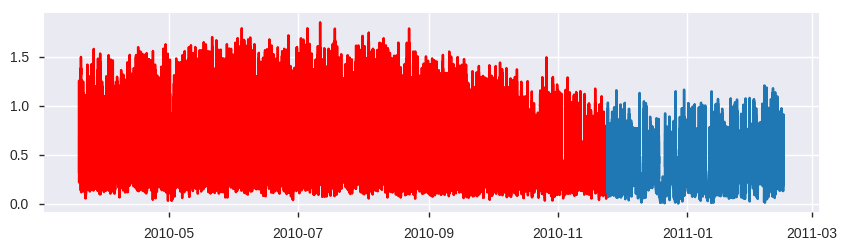

0.5924560443794082


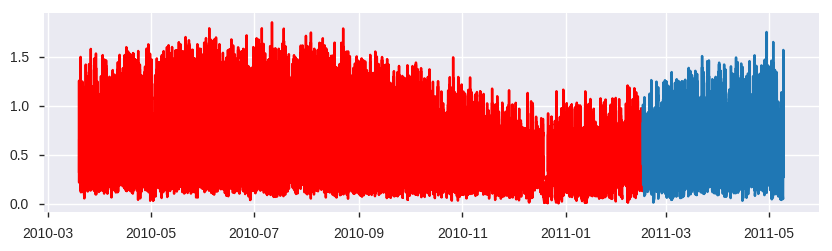

0.7272238763310943


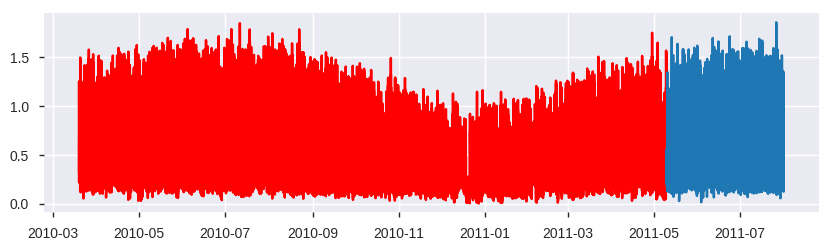

In [135]:
X_tr, y_tr = to_array_all_cov2d(df_train,[chosen_times[0]])
sensor_idx = 3
print('SENSOR:',longs_np[sensor_idx])
for i,(tr_idx, va_idx) in enumerate(TimeSeriesSplit(n_splits=5).split(X_tr)):
    plt.figure(figsize=(10,15))
    plt.subplot(5,1,i+1)
    plt.plot(df_train.index.to_numpy()[tr_idx],y_tr[tr_idx,sensor_idx],c='r')
    plt.plot(df_train.index.to_numpy()[va_idx],y_tr[va_idx,sensor_idx])
    print(y_tr[va_idx].mean())
    plt.show()
#     break

# Train Model

In [112]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [113]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape, Add, Multiply, Subtract, Dropout
from keras.layers import Conv2D, MaxPooling2D, LocallyConnected1D, Conv1D, UpSampling1D, MaxPooling1D, Dot, Concatenate
from keras.layers import LocallyConnected2D, Conv2D
from keras import backend as K
from clr import CyclicLR
from keras.layers import Layer, Conv2D, MaxPool2D, Flatten, Dense
from keras.initializers import Ones, Zeros

Using TensorFlow backend.


In [114]:
from sklearn.model_selection import TimeSeriesSplit

## Hyperparameters

In [115]:
lr = 0.0001
opt = keras.optimizers.Adam(lr=lr)
# We add a callback to log metrics and another one to schedule the learning rate
#see clr.py in this same folder
from clr import CyclicLR
c1 = keras.callbacks.BaseLogger(stateful_metrics=None)
c2 = CyclicLR(step_size=250, base_lr=lr)
c3 = keras.callbacks.History()
c4 = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks = [c2,c3,c4]
batch_size = 1 << 12   # as big as possible so we can explore many models
epochs = 1 << 5

In [130]:
def train_and_test_all(df_roll_train,chosen_times, to_array , make_model_all, longs_np= longs_np,k_folds_val = 5,verbose = 0):
    # Preprocessing
    X_tr, y_tr = to_array(df_roll_train,chosen_times, sort_time = True)
    time_slices = len(chosen_times)
    n_sensors = len(longs_np)
    
#     mean_mae_val_list = np.zeros(k_folds_val)
    mae_val_list = np.zeros((k_folds_val,n_sensors))
    # Validation using TS split (just to obtain different MAE estimations, no hyperoptimization for the moment)
    for i,(tr_idx, va_idx) in enumerate(TimeSeriesSplit(n_splits=k_folds_val).split(X_tr)):
        model = make_model_all(n_sensors=n_sensors,time_slices=time_slices)
        model.compile(optimizer = opt, loss='mean_absolute_error')
        
        model.fit(X_tr[tr_idx], y_tr[tr_idx], batch_size=batch_size, epochs=epochs, validation_data=
              (X_tr[va_idx],y_tr[va_idx]), callbacks=callbacks, verbose=verbose)
#         mean_mae_val_list[i] = c3.history['val_loss'][-1]
        mae_val_list[i] = np.mean(np.abs(model.predict(X_tr[va_idx])-y_tr[va_idx]),axis=0)
        if verbose==1:
            print('MAE_val ', mae_val_list[i].mean() ) #c3.history['val_loss'][-1])

    return model, mae_val_list

In [138]:
def print_mae_sensors(mae_val_list,longs_np, scale = 1):
    """
    mae_val_list : (k_folds_val, n_sensors)
    longs_np : (n_sensors)
    """
    mae_val_list = scale*mae_val_list
    print('====MAE VALIDATION=====')
    print('* MEAN: {:0.3f} (+/- {:0.3f})'.format(mae_val_list.mean(), mae_val_list.std()),
      '/ List: [',', '.join(['{:6.3f}'.format(mae) for mae in mae_val_list.mean(axis=1)]),']')
    print('====DISAGGREGATED======')
    for sensor,mae_list in zip(longs_np,mae_val_list.T):
        print("* {:4}: {:0.3f} (+/- {:0.3f})".format(sensor, mae_list.mean(), mae_list.std()),'/ List: [',', '.join(['{:6.3f}'.format(mae) for mae in mae_list]),']') 

## Conv2D Clearsky

In [126]:
def to_array_all_cov2d(df_roll,chosen_times,scale = 1., sort_time = True, change_negatives=True):
    ''' TODO: Pick chosen_times from df directly, and then use only numpy, instead of for loop.
    
    Converts dataframe to numpy array for predicting any given sensor.
    The X array has several time slices, given in chosen_times and
    sorts them in ascending order.
    Output shape X_np : (item, time_slice, sensor, 1), 'channels_last'
    Output shape y_np : (item, sensor)
    '''
    y = df_roll['t']
    X = df_roll.drop(columns='t', level='time')
    X_np = []
    for time in chosen_times:
        X_np.append(np.expand_dims(X[time].to_numpy(),axis=2))
    X_np = np.swapaxes(np.concatenate(X_np,axis=2),1,2)
    y_np = y.to_numpy()
    if sort_time:
        X_np = X_np[:,::-1]  
    X_np = np.expand_dims(X_np,axis=3)
    if change_negatives:
        X_np[X_np<0]=0.0
        y_np[y_np<0]=0.0
    if scale != 1. :
        X_np = X_np/scale
        y_np = y_np/scale
    assert X_np.shape[1] == len(chosen_times),'X_np does not have the correct shape'
    assert X_np.shape[0] == y_np.shape[0],'X and y do not have the same dimensions'
    assert X_np.shape[2] == y_np.shape[1],'X and y do not have the same number of sensors'
    return X_np, y_np

In [123]:
to_array_all_cov2d(df_train,chosen_times)[1].shape

(300086, 16)

In [127]:
def make_model_all_conv2d( n_sensors=17, time_slices = 1):
    ''' Returns a model using all the sensors to predict index_sensor 
    Input shape : (items, time_slice, sensor, 1), 'channels_last'
    '''
    xin = Input(shape=(time_slices,n_sensors,1), name='main_input')
    '''
    When using this layer as the first layer in a model, provide an input_shape argument 
    (tuple of integers or None, does not include the batch axis), e.g. input_shape=(10, 128) 
    for time series sequences of 10 time steps with 128 features per step in data_format="channels_last", 
    or (None, 128) for variable-length sequences with 128 features per step.
    '''
    # The convolution is across time, and each sensor is a channel
    x = LocallyConnected2D(n_sensors, 3, data_format = 'channels_last', padding='valid',activation='relu', name='LocCon1')(xin)
#     x = keras.layers.AveragePooling2D((2,2))(x)
    x = LocallyConnected2D(int(n_sensors/2), 3, data_format = 'channels_last', padding='valid',activation='relu', name='LocCon2')(x)
    x = Conv2D(n_sensors, 3, data_format = 'channels_last', padding='valid', name='Con1')(x)
    xl = Dropout(0.2,name='Dropout')(Flatten(name='Flatten1')(x))
    
    # First features
    xo = Dense(2*n_sensors, name='CFeatDense1',activation='relu')(xl)
    xo = Dense(n_sensors, name='CFeatFDense2',activation='relu')(xo)
    xo_reshaped = Reshape((1,n_sensors), name = 'CFeatFReshape')(xo)
    
    # sort of residual connection, we only take the last timestamp of the given sensor x[:,-1:,index_sensor]
    xin_0 = Activation('relu',name='RFeatRelu')(xin)
    xin_1 = Lambda(lambda x : x[:,-1:,:,0],name='RFeatLambda')(xin_0)
    
    # Weights
    # use date info here?
    xinf = Flatten()(xin)
    s  = Dense(5*n_sensors, activation='tanh',name='WFeatDense1')(xinf)
    s  = Dense(4*n_sensors, activation='tanh',name='WFeatDense2')(s)
    s  = Dense(3*n_sensors, activation='tanh',name='WFeatDense3')(s)
    s = Dense(2*n_sensors, name='WFeatDense4',activation='sigmoid')(s)
    s = Reshape((2,n_sensors),name='WFeatReshape')(s)
    # Softmax over the second axis, this is, we 2 values that sum up to one for each sensor.
#     s = Lambda(lambda x : keras.activations.softmax(x,axis=2), name = 'WFeatSoftmax')(s)
#     s = Activation(keras.activations.softmax(x,axis=1))(s)
    
    # Check dimensions here, and the axes for Concatenate and Dot, we want n_sensors outputs
    x_concat = Concatenate(axis=1, name='ConcatCandR')([xo_reshaped,xin_1])
    xo_m = Dot(axes=1, name='WeightedMean')([x_concat, s])
    # We need to take the diagonal
    def diagonal(tensor):
        out = []
        for i in range(n_sensors):
            out.append(tensor[:,i:i+1,i])
        return out
    xo_m = Lambda(diagonal, name='Diagonal')(xo_m)
    xo_m = Concatenate(axis=1, name='Tensorize')(xo_m)

    xo_m = Activation('relu', name='FinalRelu')(xo_m)

    model = Model(inputs=[xin], outputs=[xo_m])
    return model

In [133]:
model, mae_val_list = train_and_test_all(df_train,chosen_times,
                                         to_array_all_cov2d,
                                         make_model_all_conv2d,
                                         longs_np,verbose=1)
print_mae_sensors(mae_val_list,longs_np)

Train on 50016 samples, validate on 50014 samples
Epoch 1/32
50016/50016 [==============================] - 11s 220us/step - loss: 0.3234 - val_loss: 0.2718
Epoch 2/32
50016/50016 [==============================] - 1s 19us/step - loss: 0.2052 - val_loss: 0.1683
Epoch 3/32
50016/50016 [==============================] - 1s 20us/step - loss: 0.1494 - val_loss: 0.1466
Epoch 4/32
50016/50016 [==============================] - 1s 19us/step - loss: 0.1358 - val_loss: 0.1379
Epoch 5/32
50016/50016 [==============================] - 1s 19us/step - loss: 0.1303 - val_loss: 0.1338
Epoch 6/32
50016/50016 [==============================] - 1s 20us/step - loss: 0.1279 - val_loss: 0.1322
Epoch 7/32
50016/50016 [==============================] - 1s 23us/step - loss: 0.1263 - val_loss: 0.1304
Epoch 8/32
50016/50016 [==============================] - 1s 21us/step - loss: 0.1250 - val_loss: 0.1293
Epoch 9/32
50016/50016 [==============================] - 1s 19us/step - loss: 0.1240 - val_loss: 0.1277
Epo

250072/250072 [==============================] - 4s 16us/step - loss: 0.0874 - val_loss: 0.1246
Epoch 6/32
250072/250072 [==============================] - 4s 14us/step - loss: 0.0855 - val_loss: 0.1209
Epoch 7/32
250072/250072 [==============================] - 4s 14us/step - loss: 0.0846 - val_loss: 0.1201
Epoch 8/32
250072/250072 [==============================] - 4s 14us/step - loss: 0.0845 - val_loss: 0.1199
Epoch 9/32
250072/250072 [==============================] - 4s 17us/step - loss: 0.0849 - val_loss: 0.1204
Epoch 10/32
250072/250072 [==============================] - 4s 15us/step - loss: 0.0849 - val_loss: 0.1217
Epoch 11/32
250072/250072 [==============================] - 4s 14us/step - loss: 0.0850 - val_loss: 0.1188
Epoch 12/32
250072/250072 [==============================] - 4s 14us/step - loss: 0.0841 - val_loss: 0.1190
Epoch 13/32
250072/250072 [==============================] - 4s 14us/step - loss: 0.0832 - val_loss: 0.1176
Epoch 14/32
250072/250072 [=================

In [139]:
print_mae_sensors(mae_val_list,longs_np)

====MAE VALIDATION=====
* MEAN: 0.083 (+/- 0.031) / List: [  0.113,  0.075,  0.037,  0.076,  0.116 ]
====DISAGGREGATED======
* AP7 : 0.093 (+/- 0.036) / List: [  0.130,  0.084,  0.037,  0.078,  0.135 ]
* AP6 : 0.092 (+/- 0.037) / List: [  0.129,  0.083,  0.035,  0.075,  0.136 ]
* AP4 : 0.087 (+/- 0.033) / List: [  0.118,  0.076,  0.036,  0.075,  0.129 ]
* AP5 : 0.077 (+/- 0.026) / List: [  0.102,  0.066,  0.035,  0.076,  0.108 ]
* AP1 : 0.076 (+/- 0.023) / List: [  0.099,  0.071,  0.037,  0.076,  0.098 ]
* DH5 : 0.091 (+/- 0.038) / List: [  0.135,  0.077,  0.036,  0.076,  0.134 ]
* DH3 : 0.083 (+/- 0.025) / List: [  0.108,  0.088,  0.037,  0.079,  0.102 ]
* DH4 : 0.079 (+/- 0.024) / List: [  0.107,  0.075,  0.037,  0.075,  0.099 ]
* DH11: 0.082 (+/- 0.032) / List: [  0.094,  0.067,  0.040,  0.074,  0.135 ]
* DH2 : 0.083 (+/- 0.029) / List: [  0.115,  0.081,  0.035,  0.075,  0.111 ]
* DH10: 0.082 (+/- 0.033) / List: [  0.135,  0.069,  0.035,  0.076,  0.096 ]
* DH8 : 0.082 (+/- 0.034) / 